# Gallery 3: Working with Sheets
This page provides examples on:
* 2D and 3D plotting in plan view
* Extracting and plotting maximum statistics
* Plotting the difference between existing and developed conditions
* Exporting of ASCII Arc Grids
* Saving plots to disk

This notebook is used in combination with the [TUFLOW FV Python Toolbox](https://tfv.readthedocs.io/en/latest/index.html) (tfv) package. 
To follow along on your own computer, please download the demonstration notebooks from the [TUFLOW Downloads Page](https://www.tuflow.com/downloads/#utilities). Look for the TUFLOW FV Python Toolbox download.
Installation instructions are provided on our [TUFLOW FV Python Toolbox Wiki Page](https://fvwiki.tuflow.com/TUFLOW_FV_Python_Toolbox).

In [2]:
import xarray as xr  # We utilise xarray to do all the heavy lifting 
import tfv.xarray
from pathlib import Path # We'll also make use of the `pathlib` module to assist with managing file-paths, although this is entirely optional! 
import matplotlib.pyplot as plt

#### Open TUFLOW FV Model Result

In [3]:
model_folder = Path(r'..\..\data')
model_file = 'HYD_002.nc'

fv = xr.open_dataset(model_folder / model_file, decode_times=False).tfv
# fv  # Uncomment this if you want to review the contents of the Dataframe

#### Single Sheet Plot

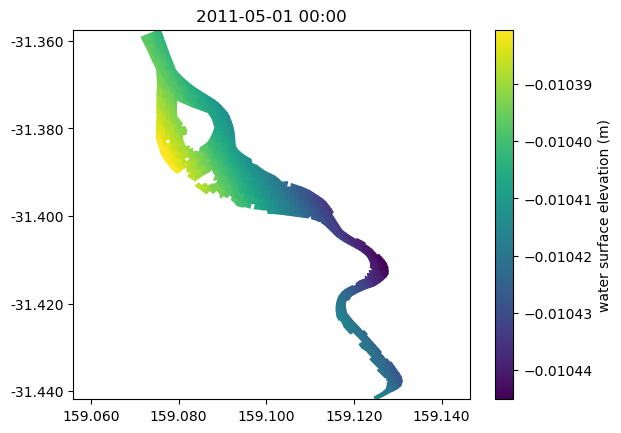

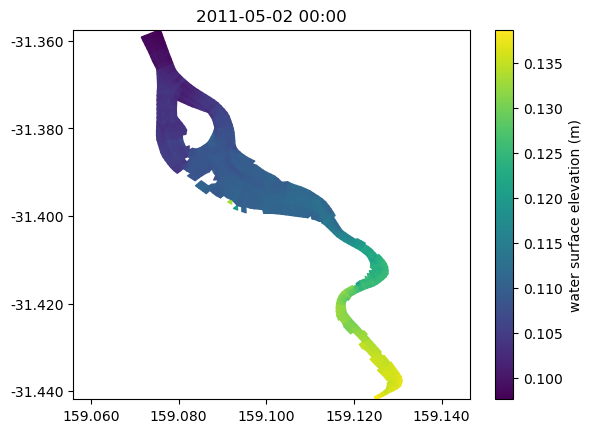

In [3]:
# Quick plot - first time step of first variable 
fv.plot()

# Plot at variable at a particular time
ts = '2011-05-02 00:00'
fv.plot('H', ts)

#### Sheet Plot With Vectors and Save to Disk

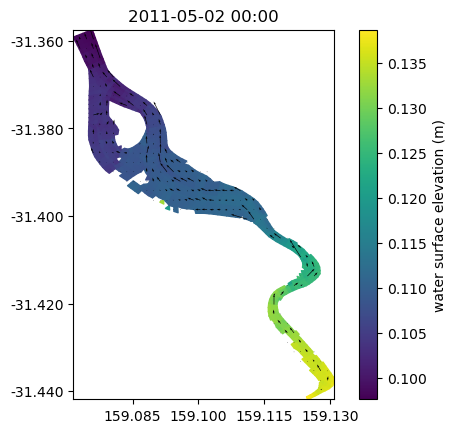

In [4]:
# Plot a variable at a particular time with vectors
ts = '2011-05-02 00:00'

# Add figure and axes
fig, ax = plt.subplots()

# Common settings
ax.set_aspect('equal')

fv.plot('H',ts, ax=ax)
fv.plot_vector('V', ts, ax=ax, color='k')   # We can plot a vector overlay using the `plot_vector` method here. This plot uses depth averaged vectors however you can use the datum and limits variable to change this.

# Save to disk
plt.savefig(Path('./plots') / 'Example_Sheet.jpg', dpi=300)


#### Sheet Plot at Different Depths

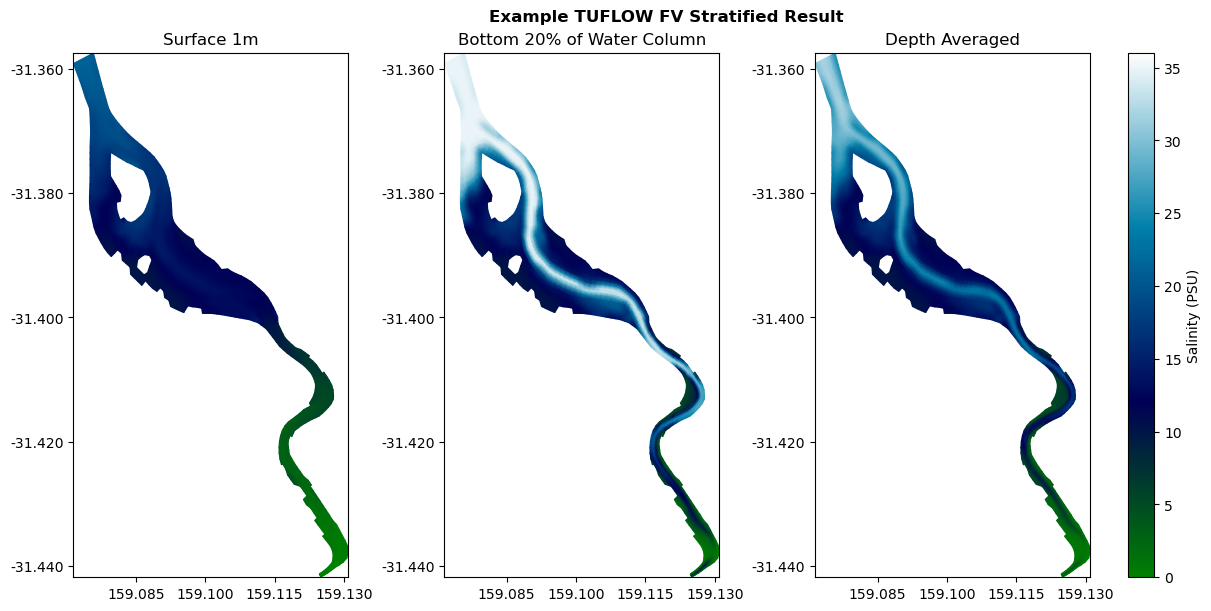

In [5]:
ts = '2011-05-02 00:00'
fig, axes = plt.subplots(ncols=3, figsize=(12, 6), constrained_layout=True)

sal_spec = dict(cmap='ocean', clim=(0, 36), shading='interp', colorbar=False)

ax = axes[0]
p1 = fv.plot('SAL', ts, ax=ax,  datum='depth', limits=(0,1), **sal_spec)  # By setting datum to depth, this is now the "surface 1m")
ax.set_title('Surface 1m')

ax = axes[1]
p2 = fv.plot('SAL', ts, ax=ax, datum='sigma', limits=(0,0.2), **sal_spec)
ax.set_title('Bottom 20% of Water Column')

ax = axes[2]
p3 = fv.plot('SAL', ts, ax=ax, **sal_spec)
plt.colorbar(p3.patch, ax=ax, orientation='vertical',label='Salinity (PSU)')
ax.set_title('Depth Averaged')

fig.suptitle('Example TUFLOW FV Stratified Result', fontweight='bold', x=0.55)
titles = {0: 'Velocity', 1: 'Salinity', 2: 'Temperature'}

#### Save Sheet To ASCII Arc Grid

In [6]:
ts = '2011-05-02 00:00'
cell_size =  5*10**-5
data = fv.xtr.get_sheet_cell('V', ts, datum='depth', limits=(0,1))

out_ascii = Path('./outputs') / 'Surface_V_2011-05-02.asc'
fv.xtr.write_data_to_ascii(out_ascii, data, cell_size)


#### Extract Grid From Sheet And Output To GeoTiff
This example shows how to write a sheet to a custom grid resolution and extent using the get_sheet_grid method. A raster is then output to geotiff using the rioxarray package. Please note that [RioXarray](https://anaconda.org/conda-forge/rioxarray) is not a requirement of the tfv package and must be installed separately via:  conda install -c conda-forge rioxarray. This install may take several minutes flexibly solve in your tfv-workspace environment. 

The get_sheet_method can be used to convert your TUFLOW FV mesh results to a regular grid. This may be useful if you need to compare TUFLOW FV results from different computational meshes, or if you need to compare a TUFLOW FV result with a data raster. For example, a DEM of surveyed bathmetry verses TUFLOW FV bed elevation outputs. 

RioXarray is a wrapper around the rasterio package that allows for easy rasterio integration with xarray. It is a very powerful package that allows for the easy export of xarray data to a variety of formats.

In [20]:
import rioxarray  # Note this is not a dependency of tfv and you will need to install seperately (see above).

# Define output path
opath = Path('./outputs') / 'raster_geotiff.tif'

# Define bounding box [xmin, ymin, xmax, ymax]
bbox = [159.08597, -31.39684, 159.09753, -31.3877]

# Extract the TUFLOW FV results to a regular grid. This example extracts a single timestep, however the default it for all timesteps. 
grd = fv.get_sheet_grid(time='2011-05-02 00:00',dx=0.00005, dy=0.00005, bbox=bbox)  

# Ouptut salinity to geotiff
grd['SAL'].rio.to_raster(opath)

#### Multiple Sheet Plots

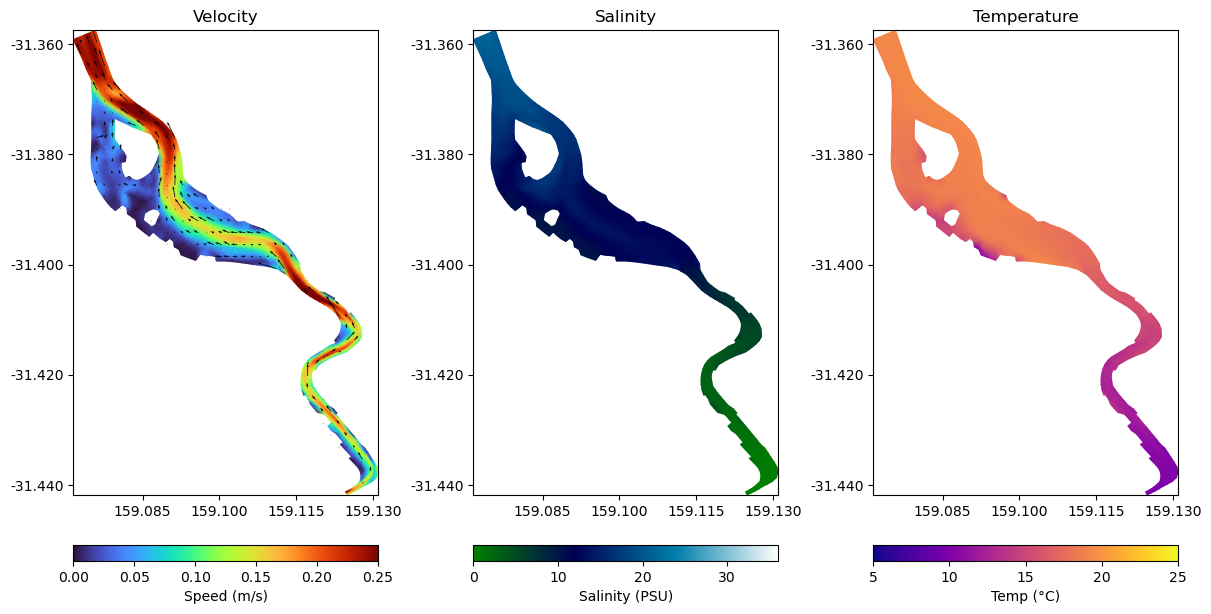

In [7]:
%matplotlib inline
# With datum='depth', this is the surface 1m. 
# Experiment with datum='height' to see how the results change. 
datum = 'depth'
limits = (0,1)

fig, axes = plt.subplots(ncols=3, figsize=(12, 6), constrained_layout=True)

ts = '2011-05-02 00:00'

ax = axes[0]
p1 = fv.plot('V', ts, ax=ax,  shading='interp', cmap='turbo', clim=(0, 0.25), datum=datum, limits=limits, colorbar=False)  # By setting datum to depth, this is now the "surface 1m")
v1 = fv.plot_vector('V', ts, ax=ax, color='k')   # We can plot a vector overlay using the `plot_vector` method here
ax.set_title('Velocity')
plt.colorbar(p1.patch, ax=ax, orientation='horizontal', label='Speed (m/s)')

ax = axes[1]
p2 = fv.plot('SAL', ts, ax=ax,  shading='interp', cmap='ocean', clim=(0, 36), datum=datum, limits=limits, colorbar=False)
ax.set_title('Salinity')
plt.colorbar(p2.patch, ax=ax, orientation='horizontal', label='Salinity (PSU)')

ax = axes[2]
p3 = fv.plot('TEMP', ts, ax=ax, shading='interp', cmap='plasma', clim=(5, 25), datum=datum, limits=limits, colorbar=False)
ax.set_title('Temperature')
plt.colorbar(p3.patch, ax=ax, orientation='horizontal', label='Temp (°C)')


#### Impact Sheet Multiple Models

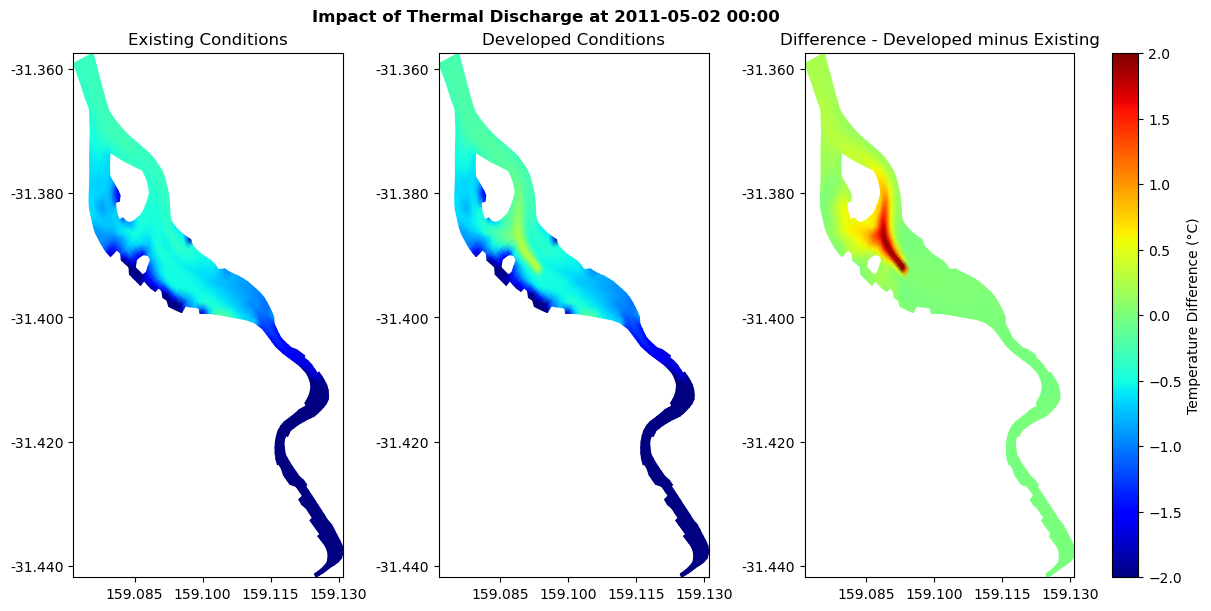

In [8]:
# Open second set of results. This model has a 40 degree celcius thermal discharge in the surface 1m. 
model_file = 'HYD_002'
model_file_therm = 'HYD_002_Thermal_Discharge.nc'  

# Open file
fv_therm = xr.open_dataset(model_folder / model_file_therm, decode_times=False).tfv

# Subtracting based on the 3D RAW DATA
fv_therm['IMPACT'] = fv_therm['TEMP'] - fv['TEMP']

ts = '2011-05-02 00:00'
fig, axes = plt.subplots(ncols=3, figsize=(12, 6), constrained_layout=True)

temp_spec = dict(cmap='jet', clim=(15, 25), shading='interp', colorbar=False)
diff_spec = dict(cmap='jet', clim=(-2, 2), shading='interp', colorbar=False)

ax = axes[0]
p1 = fv.plot('TEMP', ts, ax=ax,  datum='depth', limits=(0,1), **temp_spec)  # By setting datum to depth, this is now the "surface 1m")
ax.set_title('Existing Conditions')

ax = axes[1]
p2 = fv_therm.plot('TEMP', ts, ax=ax, datum='depth', limits=(0,1.0), **temp_spec)
ax.set_title('Developed Conditions')

ax = axes[2]
p3 = fv_therm.plot('IMPACT', ts, ax=ax, datum='depth', limits=(0,1.0), **diff_spec)
plt.colorbar(p3.patch, ax=ax, orientation='vertical',label='Temperature Difference (°C)')
ax.set_title('Difference - Developed minus Existing')

fig.suptitle('Impact of Thermal Discharge at ' + ts, fontweight='bold', x=0.45)
titles = {0: 'Existing Conditions', 1: 'Developed Conditions', 2: 'Impact'}


#### Plot Sheet Max

Text(0.5, 1.0, 'Maximum Salinity from Map Output')

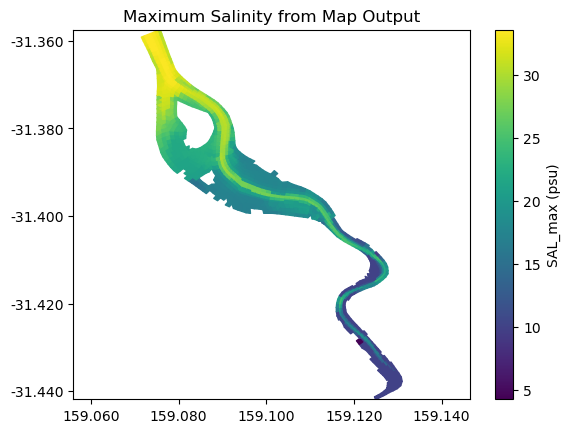

In [9]:
fv.get_statistics('max', 'SAL', datum='sigma').plot()
plt.title('Maximum Salinity from Map Output')
                  

#### Save Max to asc

In [10]:
import numpy as np

stat_max = fv.get_statistics('max', 'SAL', datum='sigma')
cell_size =  5*10**-5

out_ascii = Path('./outputs') / 'Max_Depth_Ave_Salinity.asc'
fv.xtr.write_data_to_ascii(out_ascii, np.squeeze(stat_max['SAL_max']), cell_size)

#### Save Sheet Plot Animation
To save an animation it is required to have the [FFmpeg](https://www.ffmpeg.org/download.html) program on your computer's Path environment variable.

In [11]:
out_file = Path('./outputs') / 'Salinty_Animation.mp4'
from matplotlib import animation

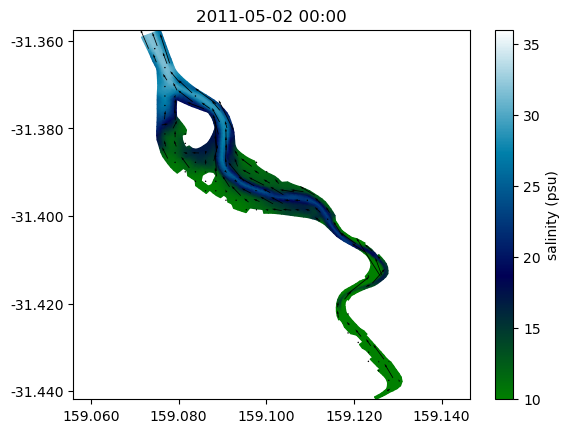

In [12]:
time_start = '2011-05-02 00:00'
time_end = '2011-05-02 12:00'

fvx = fv.sel(Time=slice(time_start, time_end))

# Colour settings
col_spec = dict(cmap='ocean', clim=(10, 36), shading='interp', edgecolor='face')

# Vector settings
vec_spec = dict(angles='uv', scale_units='dots', scale=1/200, width=0.002,
                headwidth=2.5, headlength=4, pivot='middle', minlength=2)

variable = 'SAL'
vector_variable = 'V'

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='datalim')

sheet = fvx.plot(variable, 1, ax=ax, **col_spec) 
vec = fvx.plot_vector(vector_variable, 1, ax=ax, **vec_spec) 

def animate(i):
    sheet.set_time_current(i)
    vec.set_time_current(i)
    date = sheet.get_time_current()
    ax.set_title(date.strftime('%Y-%m-%d %H:%M'))

nframes = fvx.dims['Time']
anim = animation.FuncAnimation(fig, animate, frames=nframes, repeat=False)
anim.save(
    out_file, 
    writer=animation.FFMpegWriter(),
    dpi=300)

#### Interactive Sheet Plot

GridspecLayout(children=(HBox(children=(Play(value=0, description='Play', interval=500, layout=Layout(height='…

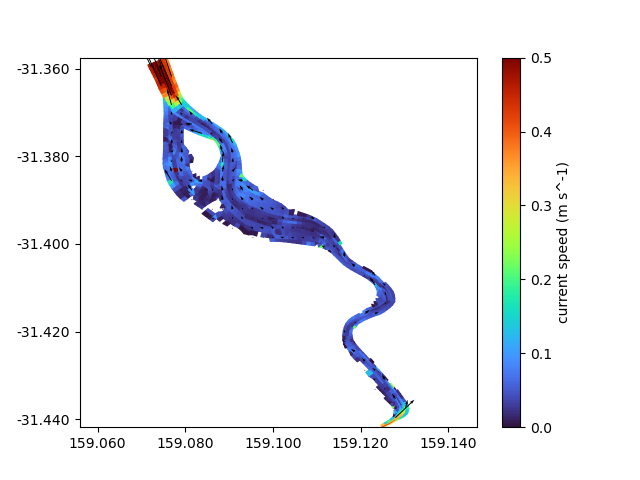

In [13]:
%matplotlib widget

fv.plot_interactive('V', cmap='turbo', clim=(0,0.5), datum='depth', vectors=True)
plt.show()


This concludes the examples on sheet plotting.